In [585]:
from micrograd.engine import Value
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [586]:
def f(x):
    return 3*x**2 - 4*x +5


In [587]:
f(3.0)

20.0

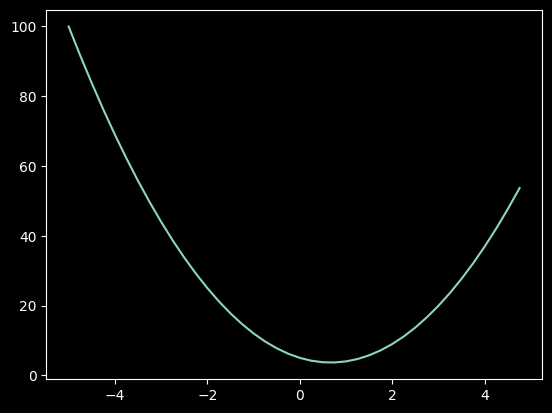

In [588]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [589]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [590]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [591]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [592]:
class Value:
    def __init__(self, data, _children =(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    

    def __radd__(self, other):
        return self + other
    
    
    def __sub__(self, other):
        return self + (-other)
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    
    def __rmul__(self, other):
        return self * other
    
    
    def __truediv__(self, other):
        return self * other**-1
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [593]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.2f | grad %.2f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [594]:

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d*f; L.label = 'L'

In [595]:
# # manully set the gradient of L to 1.0
# L.grad = 1.0
# f.grad = d.data * L.grad
# d.grad = f.data * L.grad
# c.grad = 1.0 * d.grad
# e.grad = 1.0 * d.grad
# a.grad = b.data * e.grad
# b.grad = a.data * e.grad

In [596]:
# draw_dot(L)

In [597]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad

# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = d * f 
# print(L.data)

In [598]:
# def lol():

#     h = 0.0001

#     a = Value(2.0, label='a')
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     e = a*b; e.label = 'e'
#     d = e + c; d.label = 'd'
#     f = Value(-2.0, label='f')
#     L = d*f; L.label = 'L'
#     L1 = L

#     a = Value(2.0, label='a')
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     e = a*b; e.label = 'e'
#     d = e + c; d.label = 'd'
#     f = Value(-2.0, label='f')
#     L = d*f; L.label = 'L'
#     L2 = L

#     print("slope", (L2.data - L1.data)/h)

# lol()

In [599]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')   

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [600]:
# Manual backpropagation

# o.grad = 1.0

# n.grad = (1 - o.data**2) * o.grad

# x1w1x2w2.grad = 1.0 * n.grad
# b.grad = 1.0 * n.grad

# x1w1.grad = 1.0 * x1w1x2w2.grad
# x2w2.grad = 1.0 * x1w1x2w2.grad

# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad
# x2.grad = w2.data * x2w2.grad

# draw_dot(o)

In [601]:
# Semi manual backpropagation

# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [602]:
# Automatic backpropagation

o.backward()

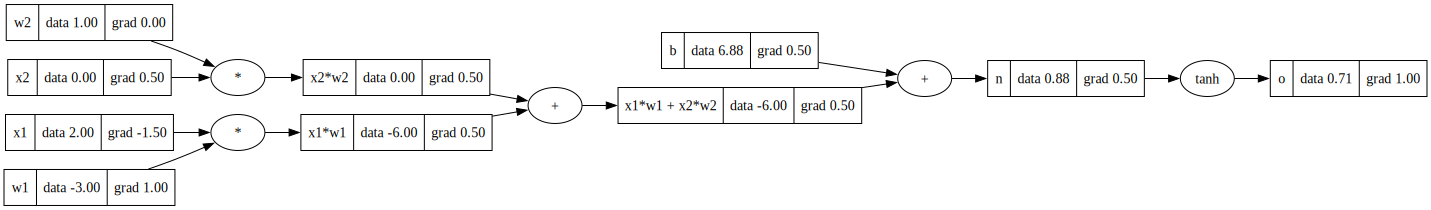

In [603]:
draw_dot(o)

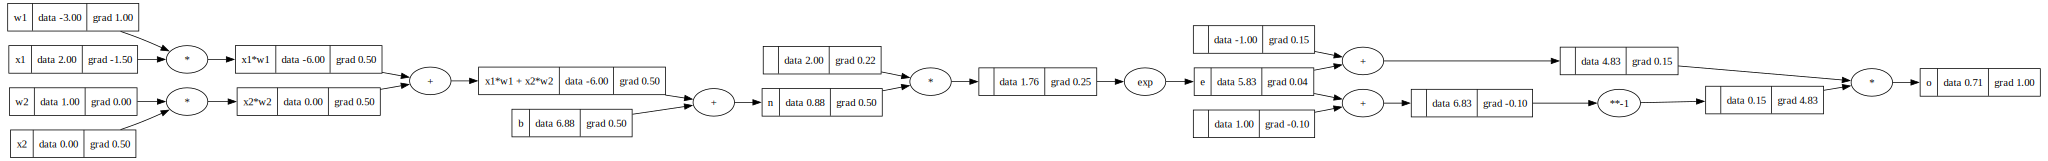

In [604]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')   

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(1 + e); o.label = 'o'

o.backward()

draw_dot(o)

In [605]:
import torch

x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())

o.backward()

print("------------------")
print("grad x1: ", x1.grad.item())
print("grad w1: ", w1.grad.item())
print("grad x2: ", x2.grad.item())
print("grad w2: ", w2.grad.item())

0.7071066904050358
------------------
grad x1:  -1.5000003851533106
grad w1:  1.0000002567688737
grad x2:  0.5000001283844369
grad w2:  0.0


In [606]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [607]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.2287067080893619)

In [608]:
len(n.parameters())

41

In [610]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [694]:
for k in range(3000):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # 0 gradient:
    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data -= 0.05 * p.grad  

    print(k, loss.data)

0 9.484858095466756e-05
1 9.482980298953874e-05
2 9.481103226822695e-05
3 9.479226878658818e-05
4 9.477351254046872e-05
5 9.475476352572089e-05
6 9.473602173820405e-05
7 9.47172871737777e-05
8 9.469855982830057e-05
9 9.467983969764404e-05
10 9.466112677767711e-05
11 9.464242106426835e-05
12 9.462372255329427e-05
13 9.460503124063732e-05
14 9.458634712217255e-05
15 9.456767019379211e-05
16 9.454900045138134e-05
17 9.453033789082806e-05
18 9.451168250802896e-05
19 9.449303429888374e-05
20 9.447439325928759e-05
21 9.445575938515146e-05
22 9.443713267237881e-05
23 9.441851311687515e-05
24 9.439990071455638e-05
25 9.438129546134188e-05
26 9.436269735314722e-05
27 9.434410638589385e-05
28 9.432552255550919e-05
29 9.430694585792057e-05
30 9.428837628905969e-05
31 9.426981384486112e-05
32 9.42512585212642e-05
33 9.423271031420554e-05
34 9.421416921963061e-05
35 9.419563523348638e-05
36 9.417710835172752e-05
37 9.415858857029798e-05
38 9.414007588515983e-05
39 9.412157029226994e-05
40 9.4103071

In [695]:
ypred 

[Value(data = 0.997142489125302),
 Value(data = -0.9971709991246432),
 Value(data = -0.9957270426793486),
 Value(data = 0.9950204128536743)]

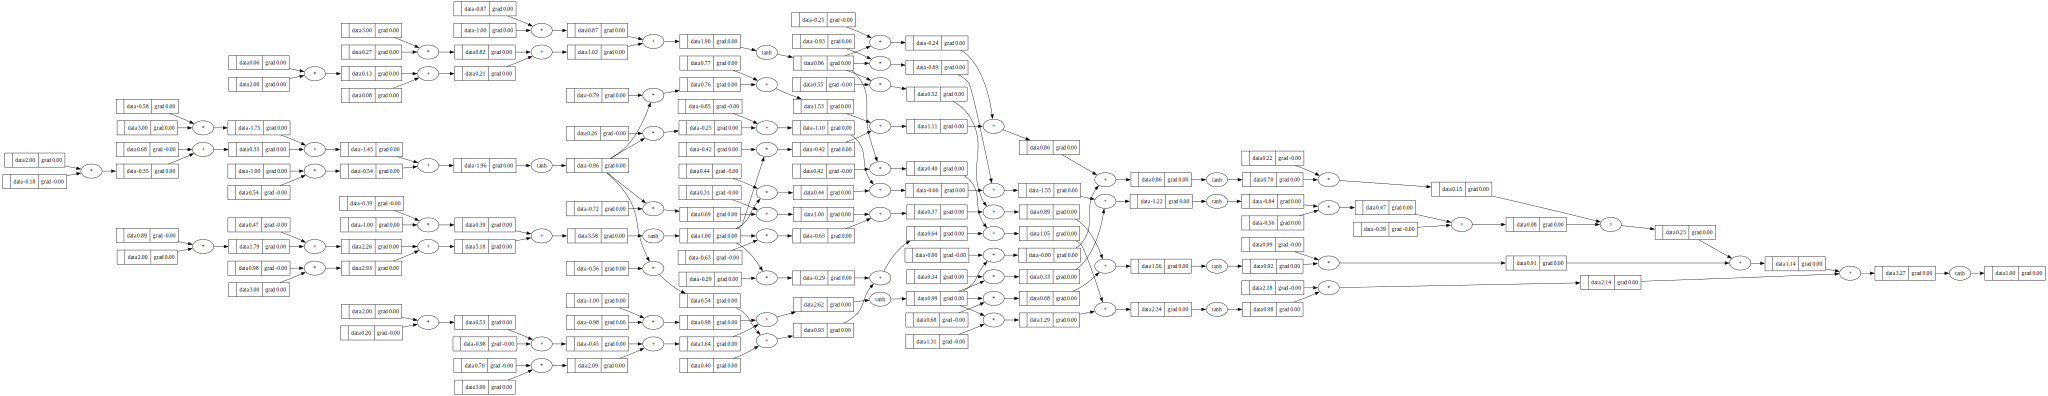

In [698]:
draw_dot(n(x))